In [140]:
import pandas as pd
import numpy as np

import dlc2kinematics
import matplotlib.pyplot as plt

# 1 As long as there are no nans and 'normal' looking data, the function works as expected

In [15]:
# Generate data with step function speed increase

# Constants
total_rows = 5000
initial_speed = 10
speed_increase = 5
number_of_rows_speed_increase = 500

# Initialize DLC-style MultiIndex DataFrame
df = pd.DataFrame(index=range(total_rows), columns= pd.MultiIndex.from_product(
    [['scorer'], ['test'], ['x', 'y', 'z']], names=["scorer", "bodyparts", "coords"]
))

# Initial speed, position, and velocity direction
current_speed = initial_speed
position = np.array([0.0, 0.0, 0.0])

velocity_direction = np.random.rand(3) + 0.5
velocity_direction /= np.linalg.norm(velocity_direction)

# Calculate rows in which the speed should change
speed_change_row = [(i+1) * number_of_rows_speed_increase for i in range(total_rows // number_of_rows_speed_increase)]
speeds = [initial_speed + speed_increase * (i+1) for i in range(total_rows // number_of_rows_speed_increase)]
speed_changes = dict(zip(speed_change_row, speeds))

# Iterate through rows, write new position
for i in range(total_rows):

    # Check if speed should change
    if i in speed_changes.keys():
        current_speed = speed_changes[i]

    # Update position
    position += velocity_direction * current_speed

    # Write position in DataFrame
    df.iloc[i] = position

# change data type to float
for col in df.columns:    df[col] = df[col].astype(float)

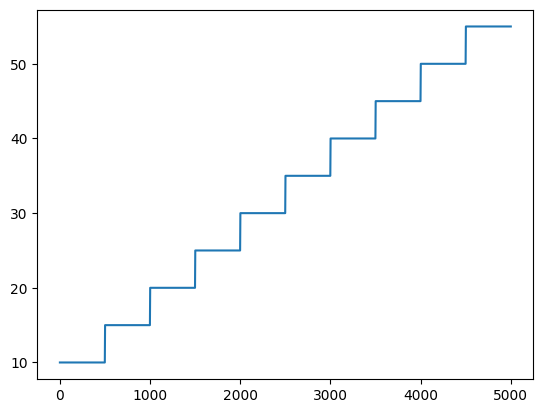

In [138]:
speed_df = dlc2kinematics.compute_speed(df, bodyparts=['test'], filter_window=3)
plt.plot(speed_df)

So far, everything looks good

# 2 Speed is set to 0 around nan values

Text(510, 20, 'End')

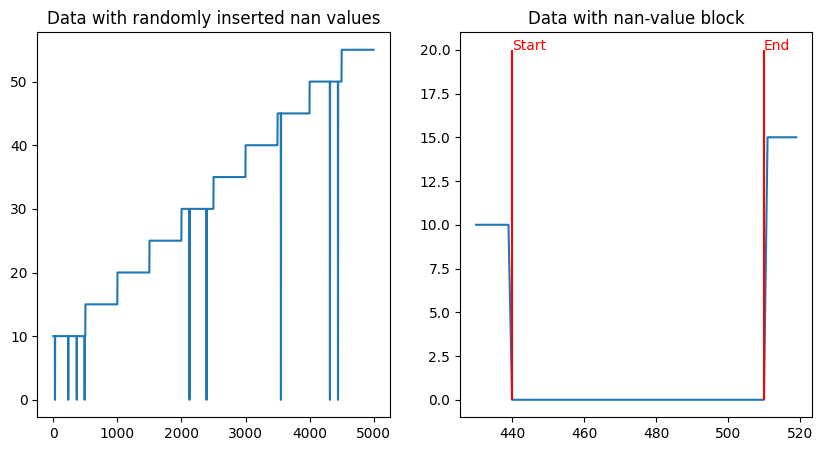

In [139]:
# visualize the handling of different kinds of nan insertions
plt.figure(figsize=(10, 5))


# show behavior of DLC2Kinematics with random NaNs in the data

plt.subplot(1, 2, 1)

df_nan = df.copy()
# generate list of random nans within range of total rows
nan_rows = np.random.randint(0, total_rows, 10)
df_nan.iloc[nan_rows] = np.nan

speed_df_nan = dlc2kinematics.compute_speed(df_nan, bodyparts=['test'], filter_window=3)

plt.plot(speed_df_nan)
plt.title('Data with randomly inserted nan values')


# show behavior of DLC2Kinematics with block of  NaNs in the data

plt.subplot(1, 2, 2)

df_nan2 = df.copy()
df_nan2.iloc[450:501] = np.nan

speed_df_nan2 = dlc2kinematics.compute_speed(df_nan2, bodyparts=['test'], filter_window=21)
# show borders of speed = 0
borders = np.where(speed_df_nan2.values == 0)[0][[0,-1]]

plt.plot(speed_df_nan2[430:520])
plt.title('Data with nan-value sequence')
plt.vlines(borders[0], 0, 20, color='r')
plt.text(borders[0], 20, 'Start', color='r')
plt.vlines(borders[1], 0, 20, color='r')
plt.text(borders[1], 20, 'End', color='r')

This nan handling is problematic. Within half of the filter window around the nan-value, the speed is set to 0. Since immobility and the mean speed are useful parameters in many behavioral analyses, the speed should rather be set to nan as well.

# 3 Data with same 'bodyparts' level but different 'scorer' breaks the function

In [137]:
# Create new df with multiple scorers and bodyparts
df_other_scorer = df.copy()
df_other_scorer.columns = pd.MultiIndex.from_product(
    [['scorer2'], ['test'], ['x', 'y', 'z']], names=["scorer", "bodyparts", "coords"]
)
df_other_scorer_other_bodypart = df.copy()
df_other_scorer_other_bodypart.columns = pd.MultiIndex.from_product(
    [['scorer2'], ['test2'], ['x', 'y', 'z']], names=["scorer", "bodyparts", "coords"]
)

df_multiple_scorers = pd.concat([df, df_other_scorer, df_other_scorer_other_bodypart], axis=1)

speed_df_multiple_scorers = dlc2kinematics.compute_speed(df_multiple_scorers, bodyparts=['all'], filter_window=3)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 4 elements

# My fix for the issue

In [ ]:
mainfxns.py in DLC2Kinematics
    # delete lines 112-117 and 119-123

    vel = traj.loc[:, coords].groupby(level=[0,1], axis=1).apply(_calc_norm)

    vel.loc[traj.groupby(level=[0,1].isna().any(axis=1).index), 'speed'] = np.nan

    vel.columns = pd.MultiIndex.from_product(
        vel.columns[0] + vel.columns[1] + [["speed"]],
        names=["scorer"] + vel.columns.names + ["coords"],
    )